# Section 1: Import Libraries

In [76]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
import seaborn as sns
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
import os
from ultralytics import YOLO  # YOLOv8 for object detection
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, LSTM, TimeDistributed


Creating new Ultralytics Settings v0.0.6 file  
View Ultralytics Settings with 'yolo settings' or at 'C:\Users\malak\AppData\Roaming\Ultralytics\settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [77]:
scvd_train_dir = r'C:\Users\malak\OneDrive\Documents\Image Processing Project\SCVD\SCVD_converted_sec_split\Train'
scvd_test_dir = r'C:\Users\malak\OneDrive\Documents\Image Processing Project\SCVD\SCVD_converted_sec_split\Test'
scvd_classes = ['Normal', 'Violence','Weaponized']

# Section 2: Feature Extraction Functions

**2.1 Extract Frames**

In [78]:
# Load the YOLOv8 model (change to your custom model if needed)
model = YOLO('yolov8n.pt')  # Replace with the correct model path

def extract_segmented_frames(video_path, frame_interval, resize_dim):
    cap = cv2.VideoCapture(video_path)
    segmented_frames = []
    frame_count = 0

    while True:
        ret, frame = cap.read()
        if not ret:
            break
        if frame_count % frame_interval == 0:
            # Resize frame for uniform processing
            resized_frame = cv2.resize(frame, resize_dim)

            # Run YOLO object detection
            results = model.predict(resized_frame)
            
            # Extract bounding boxes and crop relevant regions
            for result in results:
                for box in result.boxes:
                    x1, y1, x2, y2 = map(int, box.xyxy)  # Bounding box coordinates
                    cropped = resized_frame[y1:y2, x1:x2]  # Crop detected object
                    cropped_resized = cv2.resize(cropped, resize_dim)  # Resize cropped region
                    segmented_frames.append(cropped_resized)
        frame_count += 1

    cap.release()
    return np.array(segmented_frames)

100%|██████████| 6.25M/6.25M [00:33<00:00, 196kB/s]


In [79]:
def preprocess_videos_with_segmentation(video_dir, classes, frame_interval=10, resize_dim=(128, 128)):
    data, labels = [], []
    for class_idx, class_name in enumerate(classes):
        class_dir = os.path.join(video_dir, class_name)
        for video in os.listdir(class_dir):
            video_path = os.path.join(class_dir, video)
            segmented_frames = extract_segmented_frames(video_path, frame_interval, resize_dim)
            data.extend(segmented_frames)  # Extend with segmented frames
            labels.extend([class_idx] * len(segmented_frames))  # Assign class labels
    return np.array(data), np.array(labels)


In [80]:
def visualize_sample_frames(frames, class_label):
    """Display a few sample frames from the video."""
    plt.figure(figsize=(12, 4))  # Adjust height for compact visualization
    for i, frame in enumerate(frames[:5]):
        plt.subplot(1, 5, i + 1)
        plt.imshow(frame, cmap='gray')
        plt.axis('off')
    # Adjust the title placement
    plt.suptitle(f"Sample Frames from Class: {class_label}", y=0.85, fontsize=14)
    plt.tight_layout(rect=[0, 0, 1, 0.8])  # Reduce spacing between title and images
    plt.show()


**2.2 Extract Optical Flow Features**

In [81]:
def split_sequences(data, target, test_size=0.2, random_state=42):
    """Split sequences into train and test sets."""
    return train_test_split(data, target, test_size=test_size, random_state=random_state)


In [82]:
def prepare_data_for_lstm(data, labels, num_classes):
    """Prepare sequences and one-hot encode labels for LSTM."""
    # Flatten each frame and prepare sequences
    data = [video.reshape(video.shape[0], -1) for video in data]  # Flatten frames
    max_timesteps = max([video.shape[0] for video in data])  # Find the max sequence length
    data = pad_sequences(data, maxlen=max_timesteps, padding='post', dtype='float32', value=0.0)  # Pad sequences
    labels = to_categorical(labels, num_classes=num_classes)  # One-hot encode labels
    return np.array(data), labels

In [83]:
def build_conv_lstm_model(input_shape):
    model = Sequential()
    model.add(TimeDistributed(Conv2D(32, (3, 3), activation='relu'), input_shape=input_shape))
    model.add(TimeDistributed(MaxPooling2D((2, 2))))
    model.add(TimeDistributed(Conv2D(64, (3, 3), activation='relu')))
    model.add(TimeDistributed(MaxPooling2D((2, 2))))
    model.add(TimeDistributed(Flatten()))
    model.add(LSTM(128, return_sequences=False))
    model.add(Dense(128, activation='relu'))
    model.add(Dense(len(classes), activation='softmax'))
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

In [84]:
def train_lstm_model(model, X_train, y_train, X_test, y_test, epochs=10, batch_size=16):
    """Train the LSTM model and visualize training history."""
    history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=epochs, batch_size=batch_size)

    # Plot training and validation accuracy
    plt.figure(figsize=(10, 5))
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title('Model Accuracy')
    plt.show()

    # Plot training and validation loss
    plt.figure(figsize=(10, 5))
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Model Loss')
    plt.show()

    return model

In [85]:
def evaluate_model(model, X_test, y_test, class_names):
    """Evaluate the LSTM model."""
    y_pred = model.predict(X_test)
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_true_classes = np.argmax(y_test, axis=1)

    # Confusion Matrix
    cm = confusion_matrix(y_true_classes, y_pred_classes)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

    print("Classification Report:")
    print(classification_report(y_true_classes, y_pred_classes, target_names=class_names))


In [87]:
# Load and preprocess data
train_data, train_labels = preprocess_videos_with_segmentation(scvd_train_dir, scvd_classes)
test_data, test_labels = preprocess_videos_with_segmentation(scvd_test_dir, scvd_classes)

0: 640x640 (no detections), 224.4ms
Speed: 7.0ms preprocess, 224.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 178.5ms
Speed: 3.0ms preprocess, 178.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 205.5ms
Speed: 4.0ms preprocess, 205.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 190.5ms
Speed: 4.0ms preprocess, 190.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 187.5ms
Speed: 7.0ms preprocess, 187.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 185.5ms
Speed: 6.0ms preprocess, 185.5ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 188.5ms
Speed: 4.0ms preprocess, 188.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 189.5ms
Speed: 4.0ms prepro

ValueError: only one element tensors can be converted to Python scalars

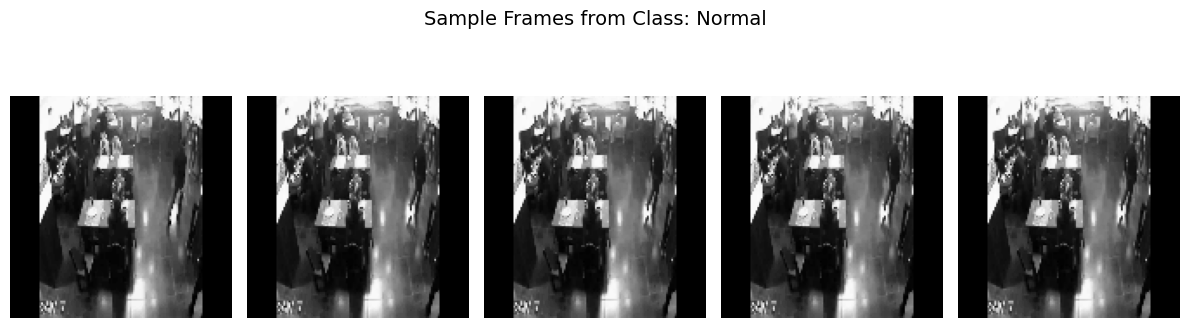

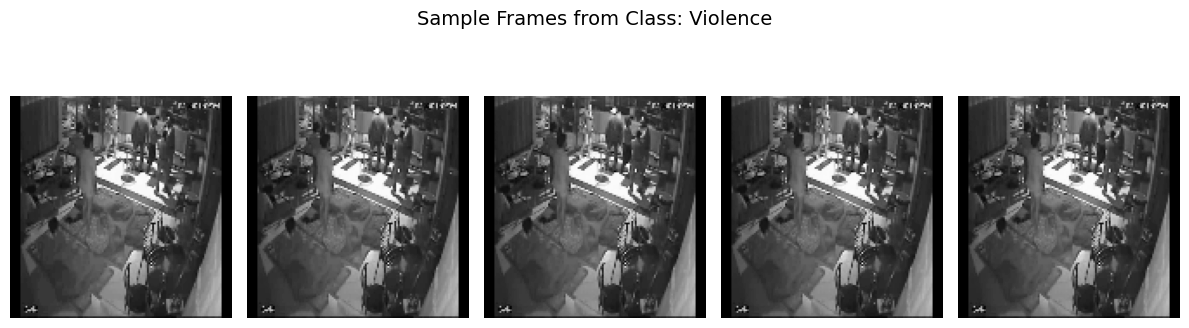

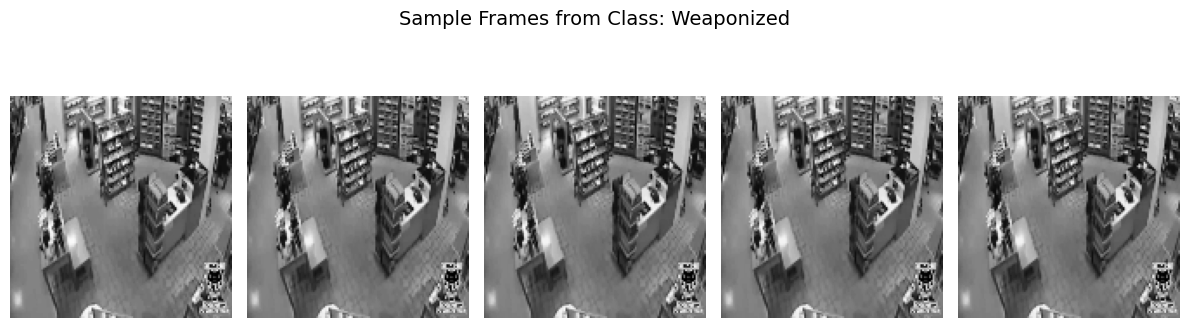

In [55]:
# Visualize sample frames from each class
for i, class_name in enumerate(scvd_classes):
    class_idx = np.where(train_labels == i)[0][0]
    visualize_sample_frames(train_data[class_idx], class_name)

In [ ]:
# Reshape data for ConvLSTM model
train_data = train_data.reshape(train_data.shape[0], -1, 128, 128, 3)
test_data = test_data.reshape(test_data.shape[0], -1, 128, 128, 3)

In [ ]:
input_shape = train_data.shape[1:]
model = build_conv_lstm_model(input_shape)

MemoryError: Unable to allocate 4.64 GiB for an array with shape (2536, 30, 16384) and data type float32

In [ ]:
history = model.fit(train_data, train_labels, validation_data=(test_data, test_labels), epochs=15, batch_size=32)

In [ ]:
# Confusion matrix
predictions = model.predict(test_data)
predicted_labels = np.argmax(predictions, axis=1)
cm = confusion_matrix(test_labels, predicted_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=scvd_classes)
disp.plot()
plt.show()

In [ ]:
# Split train data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(train_data, train_labels, test_size=0.2, random_state=42)

KeyboardInterrupt: 

In [ ]:
# Build LSTM model
input_shape = (X_train.shape[1], X_train.shape[2])  # (timesteps, features)
model = build_lstm_model(input_shape, num_classes)

# Train the model
history = train_lstm_model(model, X_train, y_train, X_val, y_val, epochs=15, batch_size=8)

MemoryError: Unable to allocate 3.25 GiB for an array with shape (1775, 30, 16384) and data type float32

In [59]:
# Plot training history
plt.figure(figsize=(10, 5))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')
plt.show()

NameError: name 'history' is not defined

<Figure size 1000x500 with 0 Axes>

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()

In [11]:
# Evaluate the model
evaluate_model(model, test_data, test_labels, scvd_classes)

KeyboardInterrupt: 

# Section 3: Load Data and Extract Features

# Section 4: Train the Machine Learning Model

**4.1 Random Forest Classifier**

**4.2 Support Vector Machine (SVM) Classifier**

# Section 5: Test the Model

**5.1 Evaluate Random Forest on Test Set**

**5.2 Evaluate SVM on Test Set**

# Section 6: Conclusion